In [1]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [2]:
outdict1 = readinput("Cu_012925.rms")

[14:57:35] WARNING: not removing hydrogen atom without neighbors
[14:57:35] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [3]:
liqspcs1 = outdict1["gas"]["Species"];
liqrxns1 = outdict1["gas"]["Reactions"];
surfspcs1 = outdict1["surface"]["Species"];
surfrxns1 = outdict1["surface"]["Reactions"];
interfacerxns1 = outdict1[Set(["surface", "gas"])]["Reactions"];
solv1 = outdict1["Solvents"][1];

In [4]:
sitedensity1 = 2.943e-5; # Cu111
sitedensity2 = 2.292e-5; # Ag111
AVratio = 36;
Phi1 = -1.414;
Phi2 = -0.614;

In [5]:
initialcondsliq = Dict(["proton"=>10.0^-4,"CO2"=>10.0^-3*10^3,
        "V"=>1.0,"T"=>298.15,"Phi"=>0.0,"d"=>0.0]);
initialcondssurf1 = Dict(["CO2X"=>0.4*sitedensity1*AVratio,
        "CHO2X"=>0.1*sitedensity1*AVratio,
        "CO2HX"=>0.1*sitedensity1*AVratio,
        "OX"=>0.1*sitedensity1*AVratio,
        "OCX"=>0.1*sitedensity1*AVratio,
        "vacantX"=>0.1*sitedensity1*AVratio,
        "CH2O2X"=>0.05*sitedensity1*AVratio,
        "CHOX"=>0.04*sitedensity1*AVratio,
        "CH2OX"=>0.01*sitedensity1*AVratio,
        "A"=>1.0*AVratio,"T"=>298.15,"Phi"=>Phi1]);

In [6]:
initialcondssurf2 = Dict(["CO2X"=>0.4*sitedensity1*AVratio,
        "CHO2X"=>0.1*sitedensity1*AVratio,
        "CO2HX"=>0.1*sitedensity1*AVratio,
        "OX"=>0.1*sitedensity1*AVratio,
        "OCX"=>0.1*sitedensity1*AVratio,
        "vacantX"=>0.1*sitedensity1*AVratio,
        "CH2O2X"=>0.05*sitedensity1*AVratio,
        "CHOX"=>0.04*sitedensity1*AVratio,
        "CH2OX"=>0.01*sitedensity1*AVratio,
        "A"=>1.0*AVratio,"T"=>298.15,"Phi"=>Phi2]);

In [7]:
liq1 = IdealDiluteSolution(liqspcs1,liqrxns1,solv1,name="liquid",diffusionlimited=true);

surf1 = IdealSurface(surfspcs1,surfrxns1,sitedensity1,name="surface");


In [8]:
domainliq1,y0liq1,pliq1 = ConstantTVDomain(phase=liq1,
    initialconds=initialcondsliq,constantspecies=["proton","CO2"]);

In [9]:
domaincat1,y0cat1,pcat1 = ConstantTAPhiDomain(phase=surf1,
    initialconds=initialcondssurf1);

inter1,pinter1 = ReactiveInternalInterfaceConstantTPhi(domainliq1,
  domaincat1,interfacerxns1,298.15,AVratio*1.0);

In [10]:
domaincat2,y0cat2,pcat2 = ConstantTAPhiDomain(phase=surf1,
    initialconds=initialcondssurf2);

inter2,pinter2 = ReactiveInternalInterfaceConstantTPhi(domainliq1,
    domaincat2,interfacerxns1,298.15,AVratio*1.0);

In [11]:
@time react1,y01,p1 = Reactor((domainliq1,domaincat1), (y0liq1,y0cat1), (0.0, 1.0e3), [inter1], (pliq1,pcat1,pinter1));

@time sol1 = solve(react1.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-16,reltol=1e-8);

ssys1 = SystemSimulation(sol1,(domainliq1,domaincat1,),(inter1,),p1);

 21.536523 seconds (51.04 M allocations: 3.047 GiB, 10.94% gc time, 99.91% compilation time: <1% of which was recompilation)
  7.551352 seconds (18.91 M allocations: 1.187 GiB, 8.74% gc time, 98.02% compilation time)


In [12]:
@time react2,y02,p2 = Reactor((domainliq1,domaincat2), (y0liq1,y0cat2), (0.0, 1.0e3), [inter2], (pliq1,pcat2,pinter2));

@time sol2 = solve(react2.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-16,reltol=1e-8);

ssys2 = SystemSimulation(sol2,(domainliq1,domaincat2,),(inter2,),p2);

  0.002376 seconds (6.54 k allocations: 3.020 MiB)
  0.275685 seconds (753.23 k allocations: 199.470 MiB, 29.83% gc time)


In [13]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [23]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

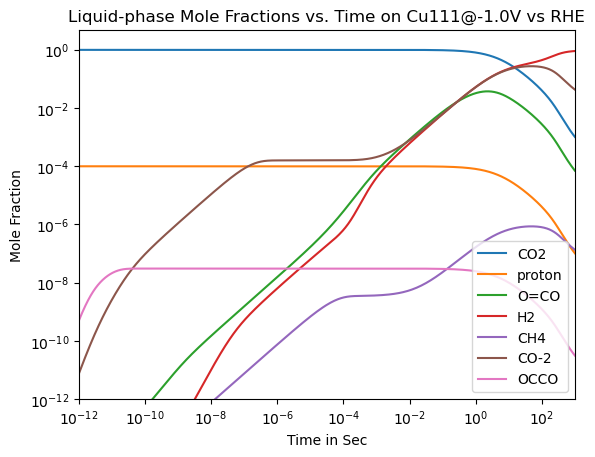

In [14]:
exclude_species = ["H2O"]
plotX(ssys1.sims[1], 1e-10, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-12, 5)
title("Liquid-phase Mole Fractions vs. Time on Cu111@-1.0V vs RHE")
gcf()

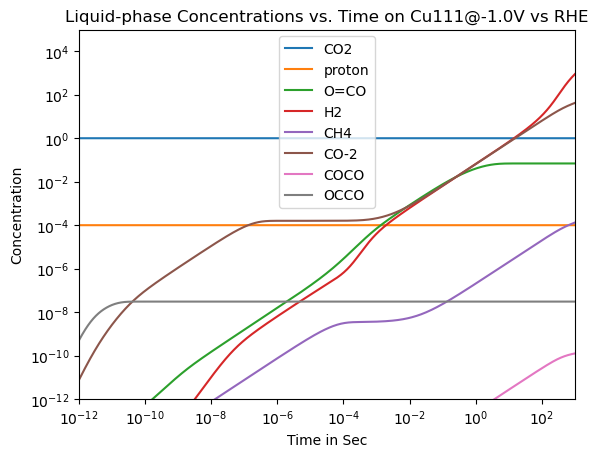

In [27]:
exclude_species = ["H2O"]
plotC(ssys1.sims[1], 1e-10, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-12, 1e5)
title("Liquid-phase Concentrations vs. Time on Cu111@-1.0V vs RHE")
gcf()

In [22]:
concentrations(ssys1.sims[1])

39×2990 Matrix{Float64}:
 0.0     0.0           0.0           …   0.0           0.0
 0.0     0.0           0.0               0.0           0.0
 0.0     0.0           0.0               0.0           0.0
 0.0     0.0           0.0               0.0           0.0
 1.0     1.0           1.0               1.0           1.0
 0.0001  0.0001        0.0001        …   0.0001        0.0001
 0.0     0.0           0.0               0.0           0.0
 0.0     3.27496e-27   6.54991e-27       3.29138e-17   3.28967e-17
 0.0     1.24107e-27   2.49736e-27       0.0691037     0.0691037
 0.0     2.50461e-21   5.00922e-21      41.9391       42.135
 ⋮                                   ⋱                
 0.0     1.02567e-110  1.48474e-89   …   7.38278e-26   7.38278e-26
 0.0     4.46254e-123  2.68246e-122      1.65112e-93   1.63978e-93
 0.0     4.39016e-85   1.58444e-84       5.88359e-47   5.88359e-47
 0.0     1.30327e-57   5.21314e-57       1.68635e-14   1.68635e-14
 0.0     1.22005e-82   9.71798e-82       4.

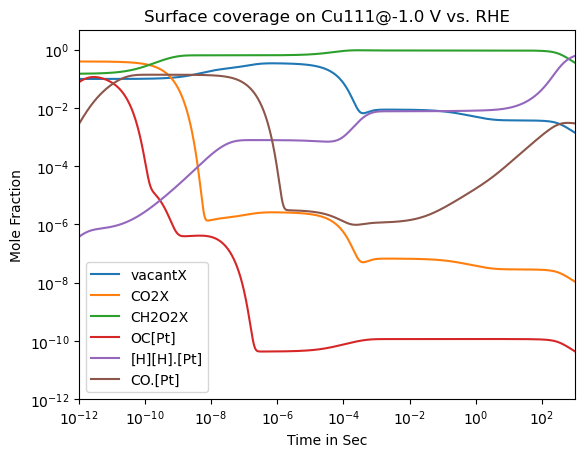

In [28]:
exclude_species = ["H2O"]
plotX(ssys1.sims[2], 0.1, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-12, 5)
title("Surface coverage on Cu111@-1.0 V vs. RHE")
gcf()

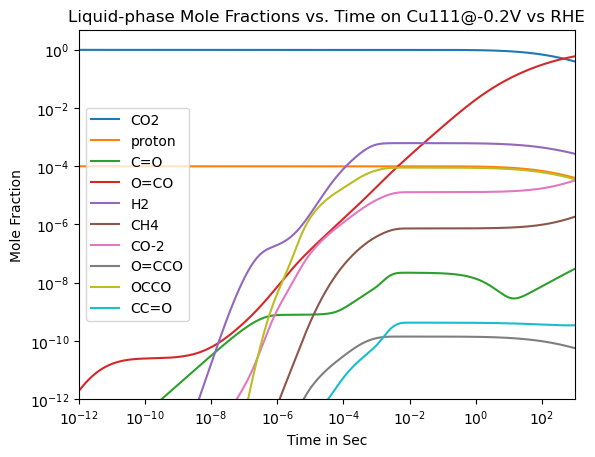

In [15]:
exclude_species = ["H2O"]
plotX(ssys2.sims[1], 1e-10, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-12, 5)
title("Liquid-phase Mole Fractions vs. Time on Cu111@-0.2V vs RHE")
gcf()

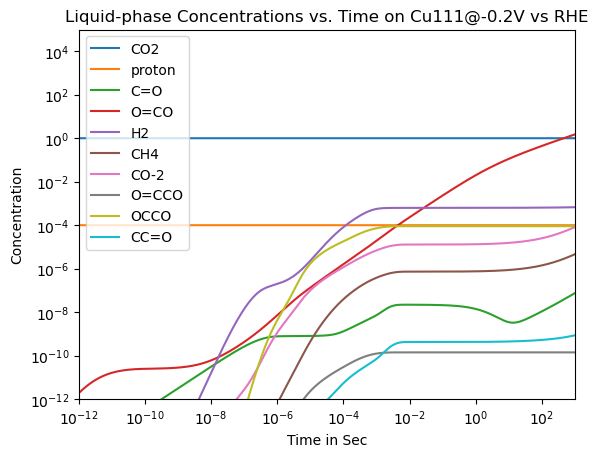

In [29]:
exclude_species = ["H2O"]
plotC(ssys2.sims[1], 1e-10, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-12, 1e5)
title("Liquid-phase Concentrations vs. Time on Cu111@-0.2V vs RHE")
gcf()